In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import sys, platform
sys.executable, platform.python_version()

('/home/mrbarinubuntu/miniconda/envs/autograd/bin/python', '3.11.9')

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
xs
ys = f(xs)
ys

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

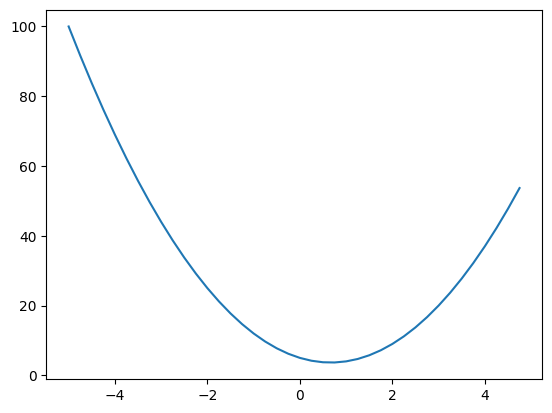

In [5]:
plt.plot(xs,ys)

In [6]:
#get the slope of the function, in DL we don't do the differentiation in the common way, in paper, we use arithmetic approaches
h = 0.0000001
x = 3.0
(f(x+h) - f(x))/h

14.000000305713911

In [7]:
#we try to use the mos approximate h (differentiable) to small we get into trouble due to computers have finite numbers
h = 0.000000000000000001
x = 3.0
(f(x + h) - f(x))/h

0.0

In [8]:
#slope is zero
h = 0.0000000001
x = 2/3
(f(x + h) - f(x)) / h

0.0

In [9]:
h = 0.000000001
x = -3.0
(f(x+h) - f(x))/h

-22.000001820288162

In [10]:
#more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [11]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

#derivative of d to respect of a
d1 = a*b + c
a += h
d2 = a*b + c #d2= (a+h) * b + c

print(f"d1={d1}")
print(f"d2={d2}")
print(f"slope={(d2 - d1)/h}")


d1=4.0
d2=3.999699999999999
slope=-3.000000000010772


In [12]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0

#derivative of d to respect of b
d1 = a*b + c
b += h
d2 = a*b + c #d2= a * (b + h) + c

print(f"d1={d1}")
print(f"d2={d2}")
print(f"slope={(d2 - d1)/h}")

d1=4.0
d2=4.0002
slope=2.0000000000042206


In [13]:
h = 0.0000001

a = 2.0
b = -3.0
c = 10.0

#derivative of d to respect of c
d1 = a*b + c
c += h
d2 = a*b + c #d2= a * b + (c + h)

print(f"d1={d1}")
print(f"d2={d2}")
print(f"slope={(d2 - d1)/h}")

d1=4.0
d2=4.000000099999999
slope=0.999999993922529


In [14]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    def __repr__(self):
        return f"Value(data={self.data})"
    def __radd__(self, other):
        return self + other
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        #for each add I want to define the function to be implemented in the backpropagation
        #considering that this is an 'add' operation, the chain derivative respect to the tahn function and the local function is 1.
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        #here it's different we use 'mul' operation so in a derivative everything dL / df = d(d * f) /df = d
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self, ), f"**{other}")
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out 
    def __rmul__(self, other):
        return self * other
    def __truediv__(self, other):
        return self * other**-1
    def __neg__(self):
        return self * -1
    def __sub__(self, other):
        return self + (-other)
    def tanh(self):
        n = self.data
        tanh = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(tanh, (self, ), _op='tanh')
        #here we use the derivative for the activation function
        def _backward():
            self.grad = (1 - tanh**2) * out.grad
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad = out.data * out.grad
        out._backward = _backward

        return out
    def backward(self):
        #topological order
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


"""
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d * f; L.label = 'L'
L
"""

"\na = Value(2.0, label = 'a')\nb = Value(-3.0, label = 'b')\nc = Value(10.0, label = 'c')\ne = a * b; e.label = 'e'\nd = e + c; d.label = 'd'\nf = Value(-2.0, label = 'f')\nL = d * f; L.label = 'L'\nL\n"

In [15]:
from graphviz import Digraph

def trace(root):
    #build a set of all nodes and edges in a grahph => using DFS (nodes <-> visited, edge <-> graph
    nodes, edges = set(), set()
    def build(value):
        if value not in nodes:
            nodes.add(value)
            for child in value._prev:
                edges.add((child, value)) #prev and next value in graph
                build(child) #stack in recursive style
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'}) #LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph create a rectangular record node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)

    return dot

def draw_dot_neuron(nodes, edges):
    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'}) #LR = left to right

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph create a rectangular record node for it
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
        if n._op:
            #if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            #and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2))+n2._op)

    return dot

In [16]:
draw_dot(L)

NameError: name 'L' is not defined

In [ ]:
#manual backpropagation
def manual_derivative(ha = 0.0, hb = 0.0, hc = 0.0, hd = 0.0, he = 0.0, hf = 0.0, hL = 0.0, h = 0.001):
    
    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d * f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label = 'a')
    a.data += ha
    b = Value(-3.0, label = 'b')
    b.data += hb
    c = Value(10.0, label = 'c')
    c.data += hc
    e = a * b; e.label = 'e'
    e.data += he 
    d = e + c; d.label = 'd'
    d.data += hd
    f = Value(-2.0, label = 'f')
    f.data += hf
    L = d * f; L.label = 'L'
    L2 = L.data + hL

    return ((L2 - L1) / h)

In [ ]:
"""
dL/dL = 1.0
((L+h) - L) /h
h/h = 1.0
"""
print(f"dL/dL = {manual_derivative(ha = 0.0, hb = 0.0, hc = 0.0, hd = 0.0, he = 0.0, hf = 0.0, hL = 0.001, h = 0.001)}")

In [ ]:
"""
dL/dL = 1.0
((L+h) - L) /h
h/h = 1.0
"""
print(f"dL/dL = {manual_derivative(ha = 0.0, hb = 0.0, hc = 0.0, hd = 0.0, he = 0.0, hf = 0.0, hL = 0.001, h = 0.001)}")

In [ ]:
"""
dL/dL = 1.0
((L+h) - L) /h
h/h = 1.0
"""
print(f"dL/dL = {manual_derivative(ha = 0.0, hb = 0.0, hc = 0.0, hd = 0.0, he = 0.0, hf = 0.0, hL = 0.001, h = 0.001)}")
L.grad = 1.0

In [ ]:
"""
L = d * f
dL/df = d
(d*(f+h) - d*f) /h
d*h/h = d = 4.0
"""
print(f"dL/dL = {manual_derivative(ha = 0.0, hb = 0.0, hc = 0.0, hd = 0.0, he = 0.0, hf = 0.001, hL = 0.0, h = 0.001)}")
f.grad = 4.0

In [ ]:
"""
L = d * f
dL/dd = f
(f*(d+h) - d*f) /h
h*f/h = f = - 2.0
"""
print(f"dL/dL = {manual_derivative(ha = 0.0, hb = 0.0, hc = 0.0, hd = 0.001, he = 0.0, hf = 0.0, hL = 0.0, h = 0.001)}")
d.grad = - 2.0

In [ ]:
"""
d = e + c
dL/de = dL / dd * dd/de
(f*(e+h+c) - (e+c)*f) /h
h*f/h = f = - 2.0
"""
print(f"dL/dL = {manual_derivative(ha = 0.0, hb = 0.0, hc = 0.0, hd = 0.0, he = 0.001, hf = 0.0, hL = 0.0, h = 0.001)}")
e.grad = - 2.0

In [ ]:
"""
d = e + c
dL/de = dL / dd * dd/de
(f*(e+h+c) - (e+c)*f) /h
h*f/h = f = - 2.0
"""
print(f"dL/dL = {manual_derivative(ha = 0.0, hb = 0.0, hc = 0.001, hd = 0.0, he = 0.0, hf = 0.0, hL = 0.0, h = 0.001)}")
c.grad = - 2.0

In [ ]:
"""
e = a*b
dL/da = dL / de * de/da
dL/da = - 2.0 * b = -2.0 * -3.0
"""
print(f"dL/dL = {manual_derivative(ha = 0.001, hb = 0.0, hc = 0.0, hd = 0.0, he = 0.0, hf = 0.0, hL = 0.0, h = 0.001)}")
a.grad = 6.0

In [ ]:
"""
e = a*b
dL/db = dL / de * de/db
dL/db = - 2.0 * a = -2.0 * 2.0
"""
print(f"dL/dL = {manual_derivative(ha = 0.001, hb = 0.0, hc = 0.0, hd = 0.0, he = 0.0, hf = 0.0, hL = 0.0, h = 0.001)}")
b.grad = -4.0

In [ ]:
draw_dot(L)

In [ ]:
"""
nudges all the values
"""
a.data += 0.001 * a.grad
b.data += 0.001 * b.grad
c.data += 0.001 * c.grad
f.data += 0.001 * f.grad

e = a * b
d = e + c
L = d * f

print(L)


In [ ]:
#tahn as activation function, squash weights
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [ ]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

In [ ]:
draw_dot(o)

In [ ]:
o.grad = 1.0

In [ ]:
1 - o.data**2

In [ ]:
#o = tanh(n)
#do/dn = 1 - tanh^2(n)
n.grad = 0.5

In [ ]:
#dn / d(x1w1x2w2)
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [ ]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [ ]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [ ]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [ ]:
draw_dot(o)

In [ ]:
#reset values
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
#change from manual to more semi manual using function
o.grad = 1.0
draw_dot(o)

In [ ]:
o._backward()
draw_dot(o)

In [ ]:
n._backward()
draw_dot(o)

In [ ]:
b._backward()
x1w1x2w2._backward()
draw_dot(o)

In [ ]:
x1w1._backward()
x2w2._backward()
draw_dot(o)

In [ ]:
o.backward()
draw_dot(o)

In [ ]:
#inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
#weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
#bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# -----
e = (2*n).exp()
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()
draw_dot(o)

In [ ]:
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print(' ----- ')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

In [ ]:
o

In [ ]:
o.item()

In [ ]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for i in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        self.nodes = set()
        self.edges = set()
    def __call__(self,x):
        self.nodes = set()
        self.edges = set()
        # w * x + b
        #def mul_wi_xi(i, wi, xi):
        #    x = wi* Value(xi, label=f"x{i+1}"); x.label=f"w{i+1}x{i+1}"
        #    return x
        #act = sum((mul_wi_xi(i, wi, xi) for i, (wi, xi) in enumerate(zip(self.w, x))), self.b)
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        out.label = 'neuron'
        self.nodes.add(out)
        for xi in x:
            self.nodes.add(xi)
            self.edges.add((xi,out))
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        self.nodes = set()
        self.edges = set()

    def __call__(self, x):
        self.nodes = set()
        self.edges = set()
        outs = [n(x) for n in self.neurons]
        for neuron in self.neurons:
            self.nodes.update(neuron.nodes)
            self.edges.update(neuron.edges)
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        #params = []
        #for neuron in self.nuerons:
        #   ps = neuron.parameters()
        #    params.extends(ps)
        #return params
        

class MLP:
    def __init__ (self, nin, nouts):
        size = [nin] + nouts
        self.layers = [Layer(size[i], size[i+1]) for i in range(len(nouts))]
        self.nodes = set()
        self.edges = set()

    def __call__(self, x):
        self.nodes = set()
        self.edges = set()
        for layer in self.layers:
            x = layer(x)
            self.nodes.update(layer.nodes)
            self.edges.update(layer.edges)
        return x, self.nodes, self.edges

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [ ]:
x = [Value(2.0, label='x1'), Value(3.0, label='x2'), Value(-1.0, label='x3')]
n = MLP(3,[4, 4, 1])
y, nodes, edges =n(x)
draw_dot_neuron(nodes, edges)

In [ ]:
xs = [
    [Value(2.0, label='x1'), Value(3.0, label='x2'), Value(-1.0, label='x3')],
    [Value(3.0, label='x1'), Value(-1.0, label='x2'), Value(0.5, label='x3')],
    [Value(0.5, label='x1'), Value(1.0, label='x2'), Value(1.0, label='x3')],
    [Value(1.0, label='x1'), Value(1.0, label='x2'), Value(-1.0, label='x3')]
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets

In [ ]:
glob_nodes = set()
glob_edges = set()
ypred = list()
for x in xs:
    y, nodes, edges = n(x)
    ypred.append(y)
    glob_nodes.update(nodes)
    glob_edges.update(edges)
ypred

In [ ]:
loss_arr = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
loss_arr
loss = sum(loss_arr)
loss

In [ ]:
loss.backward()

In [ ]:
draw_dot_neuron(glob_nodes, glob_edges)

In [ ]:
n.layers[0].neurons[0].w[0].grad

In [ ]:
n.layers[0].neurons[0].w[0].data

In [ ]:
"""
in gradient descent we are modified small step size (h = 0.01) in the direction of the gradient. 
eg: value = -0.956224740004165 grad = -0.36024077172666125
so 0.01 * grad will make the data decrease more. So the loss will go up, we want the loss go down so we take different direction
"""
for p in n.parameters():
    p.data += -0.01 * p.grad

In [ ]:
glob_nodes = set()
glob_edges = set()
ypred = list()
for x in xs:
    y, nodes, edges = n(x)
    ypred.append(y)
    glob_nodes.update(nodes)
    glob_edges.update(edges)
ypred

In [ ]:
loss_arr = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
loss_arr
loss = sum(loss_arr)
loss

In [ ]:
glob_nodes = set()
glob_edges = set()
ypred = list()
for k in range(20):
    glob_nodes = set()
    glob_edges = set()
    ypred =list()
    #forward pass
    for x in xs:
        y, nodes, edges = n(x)
        ypred.append(y)
        glob_nodes.update(nodes)
        glob_edges.update(edges)
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    #backward pass each we need to zero grad so grad does not concatenate
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.5 * p.grad

    print(k, loss.data)

print('ypred',ypred)
draw_dot_neuron(glob_nodes, glob_edges)
    